# ASTR 598 Astrostatistics
## HW2 Part 2
## Hayden Smotherman, Chris Suberlak, Winnie Wang
## To run this Notebook:

Data files have not been uploaded to github because of size. Group 2 is analyzing NSC data, which should all be in group2/HW_2/. The NSC files are generated by uploading the HW2_DL_NCS.ipynb notebook to datalab servers, running the notebook, then downloading the two .csv files that are output. For part (c), the DR12 Quasar catalog must also be downloaded.

TOC<a id='toc'></a> : 
   
   [a) r vs RA for stars](#parta)
    
   [b) proper motion for galaxies](#partb)
    
   [c) proper motion for quasars](#partc)

In [1]:
# Imports 
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd
from scipy.stats import binned_statistic_2d as bs2d 
from scipy.stats import binned_statistic as bs1d
import seaborn as sns

In [2]:
# Load the NSC data ... takes 2 mins 
# Group two is only using NSC data
table_neg = Table.read('NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('NSC_stripe82_Dec_positive.csv')

# Stack the two tables vertically 
# ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
nsc = vstack([table_neg, table_pos])

## Part (a) <a id='parta'></a> 

[Go to TOC](#toc)

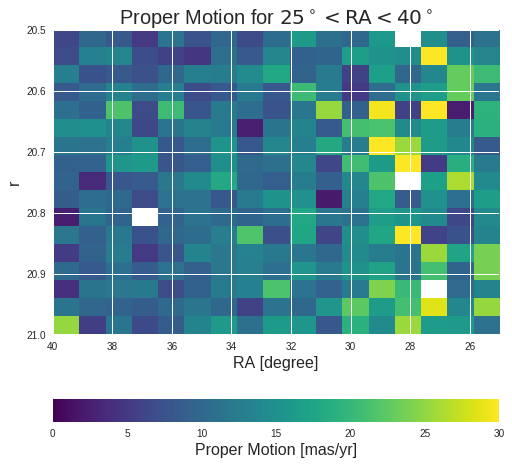

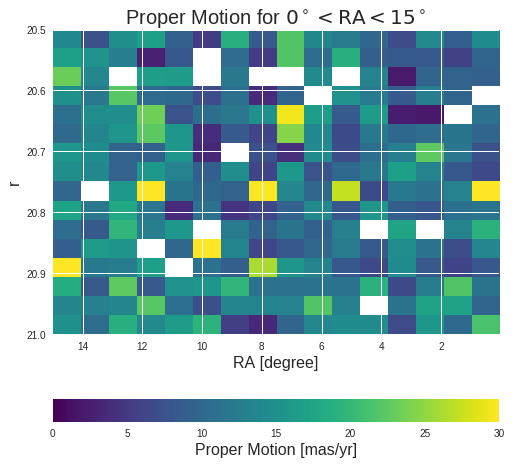

In [3]:
# Generate the magnitude mask used in the Hess diagram data analysis
def Hess_r_v_gminusi(nsc,total_mask):
    constant = 3 # This is a fudge parameter in determining number of bins
    nObjects = np.sum(total_mask)
    num_bins = int(constant * nObjects ** (1.0 / 4.0))

    # Now calculate the binned proper motions
    proper_motion = np.sqrt(nsc['pmra']**2+nsc['pmdec']**2)
    total_mask = proper_motion<100*total_mask
    Binned_PM = bs2d(nsc['ra'][total_mask],nsc['rmag'][total_mask],proper_motion[total_mask], bins = num_bins)


    #cmin = min(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))
    #cmax = max(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))

    # Define custom colormaps: Set pixels with no sources to white
    cmap = plt.cm.viridis
    cmap.set_bad('w', 1.)

    plt.figure(figsize=[8,8])
    plt.imshow(Binned_PM.statistic.T, origin='lower',
                   extent=[Binned_PM.x_edge[0], Binned_PM.x_edge[-1], Binned_PM.y_edge[0], Binned_PM.y_edge[-1]],
                   aspect='auto', interpolation='nearest', cmap=cmap)

    cb = plt.colorbar(orientation='horizontal')
    cb.set_label(r'Proper Motion [mas/yr]',fontsize=16)
    plt.clim(0, 30) # This was set by hand to draw out as much detail as possible

    plt.xlabel(r'RA [degree]',fontsize=16)
    plt.ylabel(r'r',fontsize=16)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

# Make the color masks
r_mask = (nsc['rmag']>20.5) & (nsc['rmag']<21)
gminusi_mask = ((nsc['gmag']-nsc['imag']) > 0.3) & ((nsc['gmag']-nsc['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

# Mask everything but stars
star_mask = (nsc['class_star']>0.5)

# Make the RA Masks
RA_mask_25to40 = (nsc['ra'] > 25) & (nsc['ra'] < 40)
RA_mask_0to15 = (nsc['ra'] > 0) & (nsc['ra'] < 15)

# Make the net masks
mask_25to40 = mag_mask * RA_mask_25to40 * star_mask
mask_0to15 = mag_mask * RA_mask_0to15 * star_mask

# Make the Hess diagram for 25 < RA < 40
Hess_r_v_gminusi(nsc,mask_25to40)
plt.title(r'Proper Motion for $25^\circ < \mathrm{RA} < 40^\circ$',fontsize=20)
plt.savefig('pm_Hess_Diagram_RA25to40') # Save the figure

# Make the Hess diagram for 0 < RA < 15
Hess_r_v_gminusi(nsc,mask_0to15)
plt.title(r'Proper Motion for $0^\circ < \mathrm{RA} < 15^\circ$',fontsize=20)
plt.savefig('pm_Hess_Diagram_RA0to15') # Save the figure


The Hess diagram at high-RA values seems to show some bimodality in the proper motion spacial distribution. The split occurs nearly exactly on the border of the Sagitarius stream. We don't see any such bimodality in the low-RA region.

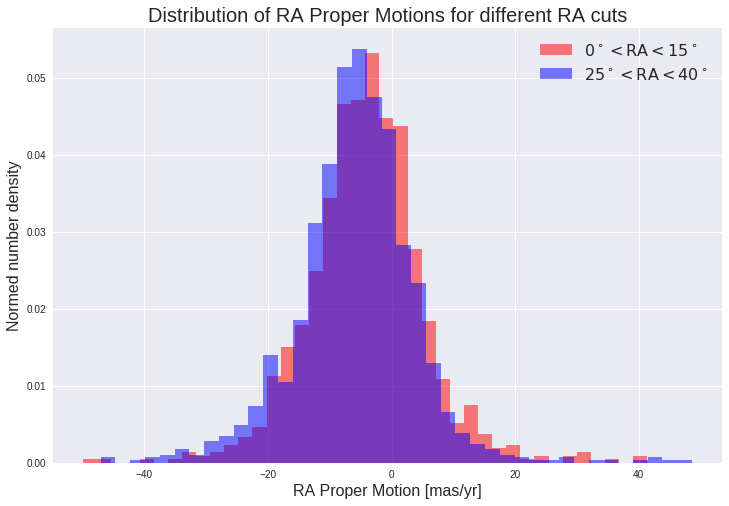

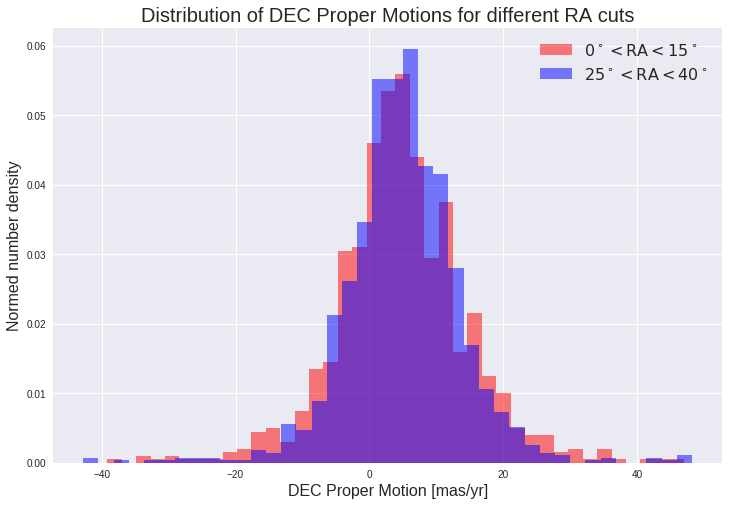

In [4]:
def ProperMotionHist(nsc,mask_noRAcuts,normed='True'):
    # This function makes a histogram of RA Proper motions for two different RA cuts
    
    # Calculate the total Proper Motion
    proper_motion = np.sqrt(nsc['pmra']**2+nsc['pmdec']**2)
    mask_noRAcuts = proper_motion<100*mask_noRAcuts
    
    # Make two masks that have the RA cuts included
    RA_mask_0to15 = (nsc['ra'] > 0) & (nsc['ra'] < 15)
    RA_mask_25to40 = (nsc['ra'] > 25) & (nsc['ra'] < 40)
    mask_0to15 = mask_noRAcuts * RA_mask_0to15
    mask_25to40 = mask_noRAcuts * RA_mask_25to40
    
    #Plot the two distributions with different RA cuts
    plt.figure(figsize=[12,8])
    plt.hist(proper_motion[mask_0to15],alpha=0.5,bins=50,normed=normed,linewidth=3,color='r')
    plt.hist(proper_motion[mask_25to40],alpha=0.5,bins=50,normed=normed,linewidth=3,color='b')

    plt.legend([r'$0^\circ < \mathrm{RA} < 15^\circ$',r'$25^\circ < \mathrm{RA} < 40^\circ$'],fontsize=16)
    plt.title('Distribution of Proper Motions for different RA cuts',fontsize=20)
    plt.xlabel('Proper Motion Number [mas/yr]',fontsize=16)
    plt.ylabel('Normed number density',fontsize=16)
    plt.xlim([0,50])
    #plt.ylim([1,200])

def ProperMotionRAHist(nsc,mask_noRAcuts,normed='True'):
    # This function makes a histogram of RA Proper motions for two different RA cuts
    
    # Calculate the total Proper Motion
    mask_noRAcuts *= np.abs(nsc['pmra'])<50
    
    # Make two masks that have the RA cuts included
    RA_mask_0to15 = (nsc['ra'] > 0) & (nsc['ra'] < 15)
    RA_mask_25to40 = (nsc['ra'] > 25) & (nsc['ra'] < 40)
    mask_0to15 = mask_noRAcuts * RA_mask_0to15
    mask_25to40 = mask_noRAcuts * RA_mask_25to40
    
    #Plot the two distributions with different RA cuts
    plt.figure(figsize=[12,8])
    plt.hist(nsc['pmra'][mask_0to15],alpha=0.5,bins=40,normed=normed,linewidth=3,color='r')
    plt.hist(nsc['pmra'][mask_25to40],alpha=0.5,bins=40,normed=normed,linewidth=3,color='b')

    plt.legend([r'$0^\circ < \mathrm{RA} < 15^\circ$',r'$25^\circ < \mathrm{RA} < 40^\circ$'],fontsize=16)
    plt.title('Distribution of RA Proper Motions for different RA cuts',fontsize=20)
    plt.xlabel('RA Proper Motion [mas/yr]',fontsize=16)
    plt.ylabel('Normed number density',fontsize=16)
    
def ProperMotionDECHist(nsc,mask_noRAcuts,normed='True'):
    # This function makes a histogram of RA Proper motions for two different RA cuts
    
    # Calculate the total Proper Motion
    mask_noRAcuts *= np.abs(nsc['pmdec'])<50
    
    # Make two masks that have the RA cuts included
    RA_mask_0to15 = (nsc['ra'] > 0) & (nsc['ra'] < 15)
    RA_mask_25to40 = (nsc['ra'] > 25) & (nsc['ra'] < 40)
    mask_0to15 = mask_noRAcuts * RA_mask_0to15
    mask_25to40 = mask_noRAcuts * RA_mask_25to40
    
    #Plot the two distributions with different RA cuts
    plt.figure(figsize=[12,8])
    plt.hist(nsc['pmdec'][mask_0to15],alpha=0.5,bins=40,normed=normed,linewidth=3,color='r')
    plt.hist(nsc['pmdec'][mask_25to40],alpha=0.5,bins=40,normed=normed,linewidth=3,color='b')

    plt.legend([r'$0^\circ < \mathrm{RA} < 15^\circ$',r'$25^\circ < \mathrm{RA} < 40^\circ$'],fontsize=16)
    plt.title('Distribution of DEC Proper Motions for different RA cuts',fontsize=20)
    plt.xlabel('DEC Proper Motion [mas/yr]',fontsize=16)
    plt.ylabel('Normed number density',fontsize=16)
    
# Make some universal cuts
r_mask = (nsc['rmag']>20.5) & (nsc['rmag']<21)
gminusi_mask = ((nsc['gmag']-nsc['imag']) > 0.3) & ((nsc['gmag']-nsc['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

# Mask everything but stars
star_mask = (nsc['class_star']>0.5)

ProperMotionRAHist(nsc,mag_mask*star_mask)
ProperMotionDECHist(nsc,mag_mask*star_mask)

When normalized, there is very little difference between the high and low RA cuts of the proper motion distributions.

## Part (b) <a id='partb'></a>

[Go to TOC](#toc)

In [5]:
#setting up data:
result = nsc # quick alias

#make mask to find galaxies
SG = result['class_star']
mask_galaxy = result['class_star'] > 0.5
mask_star = result['class_star'] < 0.5

ra = result['ra'][mask_galaxy]
dec = result['dec'] 

pmra = result['pmra'][mask_galaxy] 
pmdec = result['pmdec'][mask_galaxy] 
pmraerr = result['pmraerr'][mask_galaxy] 
pmdecerr = result['pmdecerr'][mask_galaxy]

chi_ra = pmra / pmraerr
chi_dec = pmdec / pmdecerr

raW = np.where(ra>180, ra-360, ra)

In [6]:
#masks to limit the data we are plotting
mask = np.abs(pmra) < 100
mask2 = np.abs(pmdec) < 100 
mask3 = np.abs(chi_ra) < 100
mask4 = np.abs(chi_dec) < 100

Histogram plots for proper motion in R.A and Dec:

/home/hayden/.anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


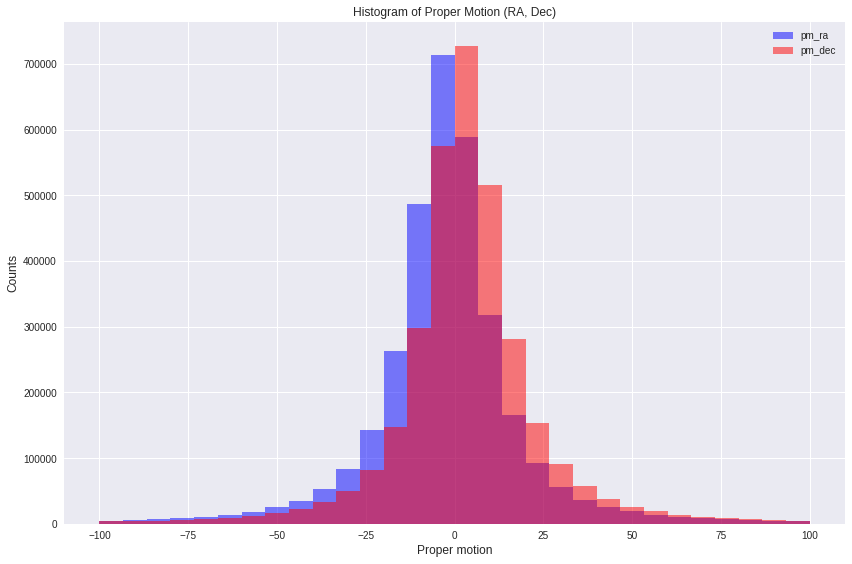

In [8]:
n_bins = 30
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=[12,8])

# We can set the number of bins with the `bins` kwarg
axs.hist(pmra[mask], alpha=0.5, bins=n_bins, color='b', label="pm_ra")
axs.hist(pmdec[mask2], alpha=0.5, bins=n_bins, color='r',label="pm_dec")

plt.legend()
axs.set_xlabel('Proper motion',fontsize=12)
axs.set_ylabel('Counts',fontsize=12)
axs.set_title('Histogram of Proper Motion (RA, Dec)')

Histogram plots for chi^2==pm/pmerr in R.A and Dec:

/home/hayden/.anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median of chi_ra: -0.0142092344157
Median of chi_dec: 0.449533586548


/home/hayden/.anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


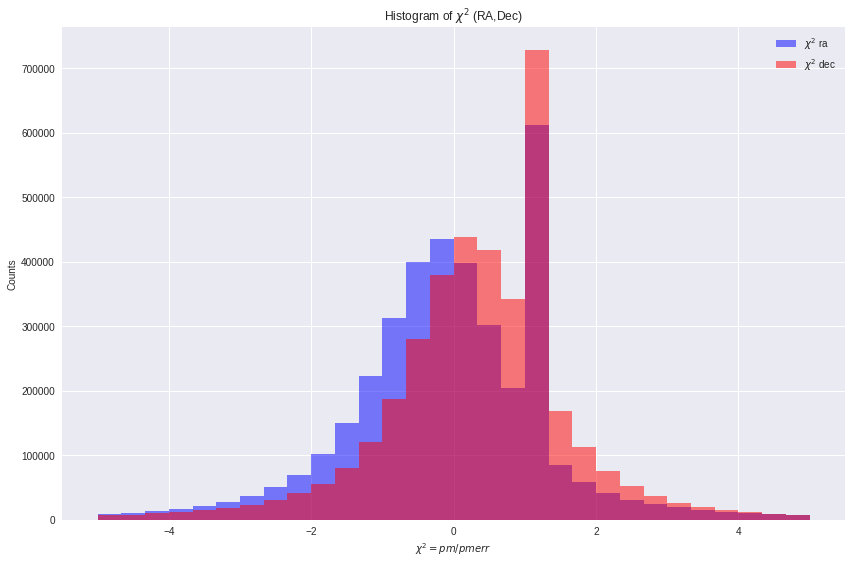

In [9]:
n_bins = 30
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=[12,8])
n_chi_ra = len(chi_ra)
n_chi_dec = len(chi_dec)

print("Median of chi_ra: "+str(np.median(chi_ra)))
print("Median of chi_dec: "+str(np.median(chi_dec)))

chi_ra_mask = (chi_ra > -5) & (chi_ra < 5)
chi_dec_mask = (chi_dec > -5) & (chi_dec < 5)

axs.hist(chi_ra[mask3*chi_ra_mask], alpha=0.5, bins=n_bins, color='b', label="${\chi}^{2}$ ra")
axs.hist(chi_dec[mask4*chi_dec_mask], alpha=0.5, bins=n_bins, color='r', label="${\chi}^{2}$ dec")

plt.legend()
axs.set_xlabel('${\chi}^{2} = pm/pmerr$',fontsize=10)
axs.set_ylabel('Counts',fontsize=10)
axs.set_title("Histogram of ${\chi}^{2}$ (RA,Dec)")

Since ${\chi}^{2}$ for Dec. is far away from zero, we plotted functions of PM_ra and PM_dec vs. RA:

Plot of PM_ra vs. RA:

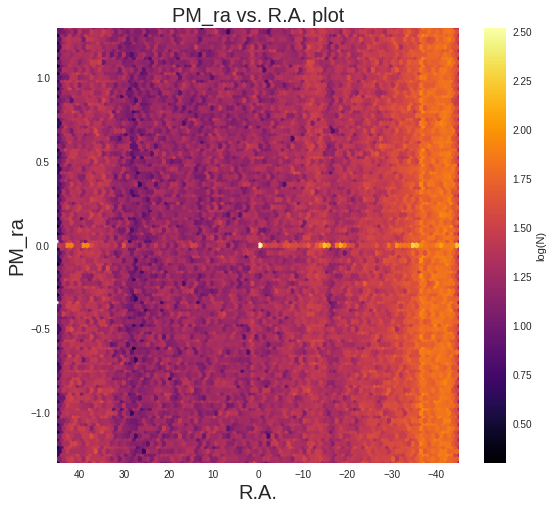

In [10]:
col0 = raW
#col1 = dec 
col2 = pmra
#print(col0.size)

fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col2, bins='log', cmap=plt.cm.inferno,
               mincnt=1, extent=(-45, 45.0, -1.3, 1.3))

ax1.axis([45, -45, -1.3, 1.3])
ax1.set_xlabel('R.A.',fontsize=20)
ax1.set_ylabel('PM_ra',fontsize=20)
ax1.set_title('PM_ra vs. R.A. plot',fontsize=20)

cb = plt.colorbar(im1,label='log(N)') #color bar

Plot of PM_dec vs. RA:

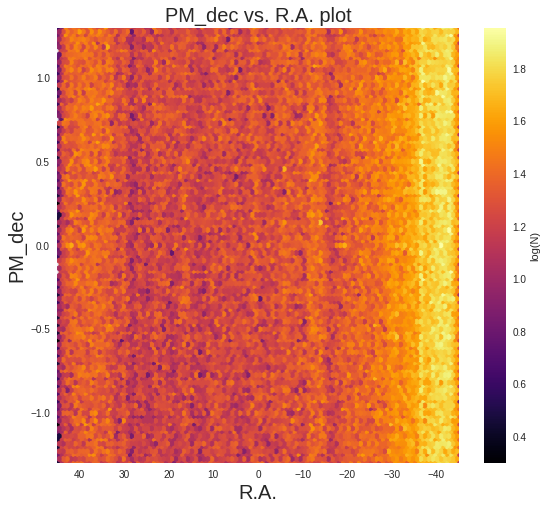

In [11]:
# median is off from zero; plotting of pm_dec vs. ra

col0 = raW
#col1 = dec 
col2 = pmdec
#print(col0.size)

fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col2, bins='log', cmap=plt.cm.inferno,
               mincnt=1, extent=(-45, 45.0, -1.3, 1.3))

ax1.axis([45, -45, -1.3, 1.3])
ax1.set_xlabel('R.A.',fontsize=20)
ax1.set_ylabel('PM_dec',fontsize=20)
ax1.set_title('PM_dec vs. R.A. plot',fontsize=20)

cb = plt.colorbar(im1,label='log(N)')#color bar

## Part (c) <a id='partc'></a>

[Go to TOC](#toc)

"Systematic errors in HLC, NSC (and joint) proper motions can be
also be gauged using ~10,000 quasars from the catalog DR12Q.fits from
http://www.sdss.org/dr12/algorithms/boss-dr12-quasar-catalog/"

"plot the median and sigmaG vs. RA for RA and Dec proper motion 
components for quasars with 17 < r < 20 from that file (~1 deg wide 
bins in RA, but try a factor of 3 smaller and larger bins and discuss). "


**TLDR** : first I [compare DR9 and DR12](#partc1) , to see if DR9 is indeed the subset of DR12 as we would expect.  I make the [union of the two catalogs](#partc2). Then I use the combined DR9-DR12 to use the positions of known QSO to obtain the [PM data from NSC catalog](partc3). We plot the sigmaG, median for the PM components. 

Comparison of DR9 and DR12 <a id='partc1'></a> 

In [12]:
# Read in DR12
hdu = fits.open('DR12Q.fits')
#hdu.info()
dr12 = Table(hdu[1].data)

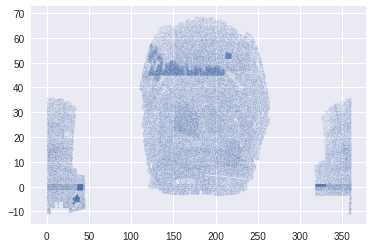

In [13]:
# quickly check coverage ...
%matplotlib inline
plt.scatter(dr12['RA'], dr12['DEC'], s=0.001)
# entire SDSS pretty much ! 

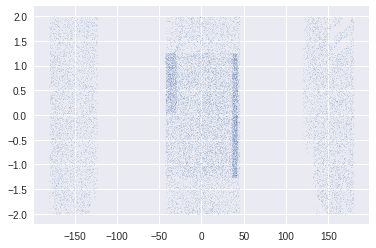

In [14]:
%matplotlib inline
# re-express the ra from 0-360 to +/- 180 ..
dr12['RA_W'] = np.where(dr12['RA']>180, dr12['RA']-360, dr12['RA'])

# Plot only the selection 
m = np.abs(dr12['DEC']) < 2
plt.scatter(dr12['RA_W'][m], dr12['DEC'][m], s=0.01)

In [15]:
# Consider Chelsea's DB9 QSO catalog
# from http://faculty.washington.edu/ivezic/cmacleod/qso_dr7/Southern.html
dr9 = Table.read('DB_QSO_S82.dat', format='ascii',
                names=['dbID', 'ra','dec','SDR5ID', 'M_i', 'M_i_corr',
                      'redshift', 'M_BH', 'Lbol', 'u','g','r','i','z','Au'])
dr9['raW'] = np.where(dr9['ra']>180, dr9['ra']-360, dr9['ra'])

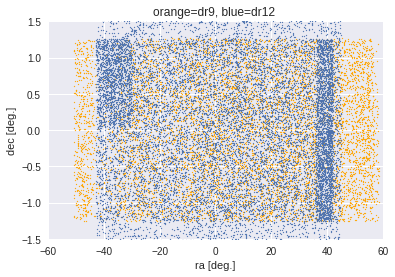

In [16]:
# Overplot DR9 and DR12 within S82 footprint...

plt.scatter(dr9['raW'], dr9['dec'], s=1, c='orange')
plt.scatter(dr12['RA_W'], dr12['DEC'], s=1)
plt.xlim(-60,60)
plt.ylim(-1.5,1.5)
plt.xlabel('ra [deg.]')
plt.ylabel('dec [deg.]')
#plt.legend(loc=[1.05,0.8], edgecolor='black')
plt.title('orange=dr9, blue=dr12 ')
plt.savefig('hw2_2c_dr9_dr12_qso_compare.png', bbox_inches='tight')

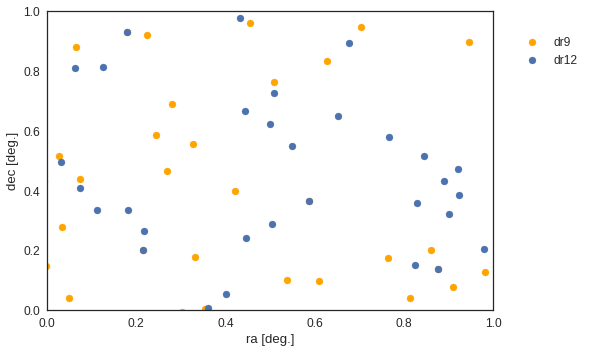

In [17]:
import seaborn as sns
sns.set(style='white', font_scale=1.2)
# Consider a small cutout...
s = 5
plt.scatter(dr9['raW'], dr9['dec'],  label='dr9', c='orange')
plt.scatter(dr12['RA_W'], dr12['DEC'], label='dr12')
plt.xlim(-0,1)
plt.ylim(-0,1)
plt.xlabel('ra [deg.]')
plt.ylabel('dec [deg.]')
plt.legend(loc=[1.05,0.8], edgecolor='black')
plt.savefig('hw2_2c_dr9_dr12_qso_compare_small_region.png', bbox_inches='tight')

So for some reason indeed in the two catalogs we have vastly different sources! No wonder that the overlap is pretty tiny ...

Matching  9258  DR9 S82 qso
Against  297301  DR12 catalog sources...
Done crossmatching
Of  9258  QSO, we matched  1998 within  0.5  arcsec


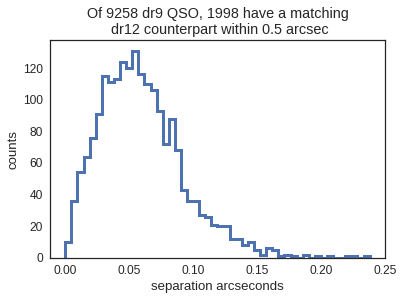

In [18]:
# Check whether all QSO from DR9 are indeed in DR12 ...
print('Matching ', len(dr9), ' DR9 S82 qso')
print('Against ', len(dr12), ' DR12 catalog sources...')

coords1 = SkyCoord(ra = dr9['raW']*u.degree, 
                   dec=dr9['dec']*u.degree) 
coords2 = SkyCoord(ra = dr12['RA_W']*u.degree, 
                   dec= dr12['DEC']*u.degree) 

# this is matching HLC to NSC, so that indices are into NSC catalog
# makes sense in this case since the NSC catalog is bigger than HLC here 
idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)  
print('Done crossmatching')

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
dr9_12 = hstack([dr9, dr12[idx]], table_names = ['dr9', 'dr12'])
dr9_12['sep_2d_arcsec'] = d2d.arcsec

%matplotlib inline
# plot the separation , select only good matches : 
x = dr9_12['sep_2d_arcsec']
plt.hist( x[x<0.5],histtype='step', bins=50, lw=3)
plt.xlabel('separation arcseconds')
plt.ylabel('counts')


# Choose separation, and select only those object that have a nearest neighbor 
# from the DB12 catalog within this radius ...
sep = 0.5
matched = dr9_12['sep_2d_arcsec'] < sep
dr9_12_matched =  dr9_12[matched]
print('Of ', len(matched), ' QSO, we matched ', np.sum(matched), 'within ',sep,' arcsec')

plt.title('Of '+str(len(matched))+' dr9 QSO, '+ str(np.sum(matched))+
         ' have a matching\n dr12 counterpart within '+str(sep)+' arcsec')
plt.savefig('hw2_2c_dr9_dr12_matching_qso.png', bbox_inches='tight')

That's very little! It would be 9258 if indeed DR9 were a subset of DR12... It does not seem to be the case ... 

In [19]:
#dr9_12_matched

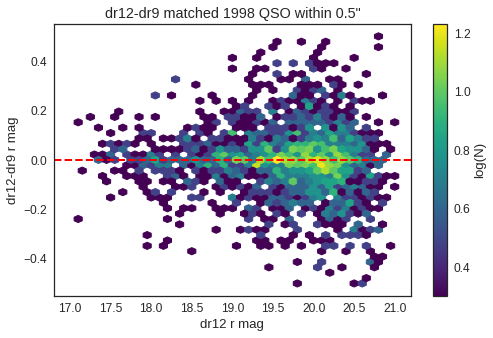

In [20]:
# Consider the matched sources: are the magnitudes the same ? 
fig,ax = plt.subplots(1,1,figsize=(8,5))
mag12 = Table(dr9_12_matched['PSFMAG'], names=('u', 'g', 'r', 'i','z'))
r9 = dr9_12_matched['r']
r12 = mag12['r']
x = r12
y = r12 - r9
im1 = ax.hexbin(r12, r9-r12, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(17,21,-0.5,0.5 ),gridsize=40 )
cb = plt.colorbar(im1,label='log(N)')
ax.axhline(0, ls='--', lw=2, c='red')
ax.set_xlabel('dr12 r mag')
ax.set_ylabel('dr12-dr9 r mag')
ax.set_title('dr12-dr9 matched '+str(len(dr9_12_matched))+' QSO within 0.5"')

Looks good : means we are using (roughly) the same magnitudes. I wonder why they are not **exactly** the same : I would have thought that the PSFmagnitudes did not change from one catalog to another, unless they added more observations, and since QSO are variable, that could have slightly shifted their mean colors (if that's what is being reported in eg DR9 as 'r' or DR12 as 'PSFMAG r'')

**Combine the two catalogs .... **

Remove from DR9 sources  that are already included in DR12. Call that DR9_new.  Use it to add points to the plots of PM using the NSC data. 

In [21]:
dr9_new = dr9[np.bitwise_not(np.in1d(dr9['dbID'], dr9_12_matched['dbID']))]

Now plot the distributions of magnitudes of those sources that already are in DR12, as well as those that are unique to DR9 : 

In [22]:
dr9_new[4]

dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,M_BH,Lbol,u,g,r,i,z,Au,raW
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,0.28137


For DR12
Of  14852  QSO within S82 footprint,  2517  are within 17 < r < 20
For DR9 unique QSO
Of  6399  QSO within S82 footprint,  3938  are within 17 < r < 20


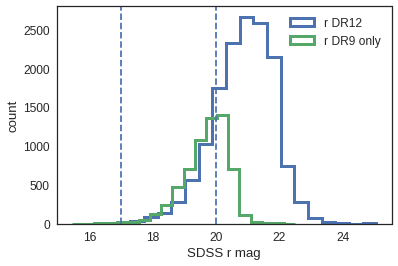

In [23]:
# DR12 

# All that has to do with 'MAG' : 
#cols = np.ravel(db_qso[m_qso].colnames)
#cols[np.array(['MAG' in x for x in  cols])]

# Grab SDSS magnitudes and errors for QSO, 
# probably more accurate than the NSC ones...
mag = Table(dr12['PSFMAG'], names=('u', 'g', 'r', 'i','z'))
magerr = Table(dr12['ERR_PSFMAG'], names=('u', 'g', 'r', 'i','z'))

m_dec = np.abs(dr12['DEC']) < 2
m_ra = np.abs(dr12['RA_W']) < 50 
#for f in 'ugriz' : 
f = 'r'
m_mag = 15 < mag[f]
magmin, magmax = 17,20
plt.hist(mag[m_dec*m_ra*m_mag][f], histtype='step', bins=20, lw=3, label=f+' DR12')

m_mag = (magmin< mag[f])*(mag[f]<magmax)
print('For DR12')
print('Of ', np.sum(m_ra*m_dec),' QSO within S82 footprint, ',
      np.sum(m_ra*m_dec*m_mag), ' are within' , magmin, '<',f,'<', magmax)

#DR9 : 
m_dec = np.abs(dr9_new['dec'])<2
m_ra = np.abs(dr9_new['raW']) < 50
m_mag = 15 < dr9_new[f]
plt.hist(dr9_new[f][m_dec*m_ra*m_mag], histtype='step', bins=20, lw=3, 
         label=f+' DR9 only')

m_r = (magmin< dr9_new[f])*(dr9_new[f]<magmax)
print('For DR9 unique QSO')
print('Of ', np.sum(m_ra*m_dec),' QSO within S82 footprint, ',
      np.sum(m_ra*m_dec*m_r), ' are within' , magmin, '<',f,'<', magmax)



plt.axvline(magmin, ls='--')
plt.axvline(magmax, ls='--')
plt.legend()

plt.xlabel('SDSS '+f+' mag')
plt.ylabel('count')
plt.savefig('hw2_2c_dr9_dr12_magnitude_distr.png', bbox_inches='tight')

In [24]:
#plt.scatter(dr9_new['raW'], dr9_new['dec'])

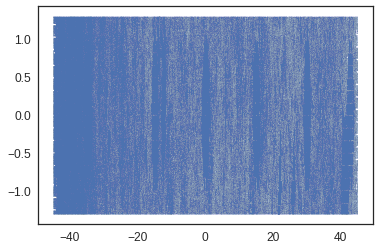

In [25]:
#Plot the NSC coverage
nsc['ra_W'] = np.where(nsc['ra']>180, nsc['ra']-360, nsc['ra'])

# Now show what we have from NSC 
# that's just S82 because that's what we queried for ...
plt.scatter(nsc['ra_W'], nsc['dec'], s=0.0001)

In [26]:
#Combine only selected columns from the two catalogs ..

# select few cols from DR12 
mag = Table(dr12['PSFMAG'], names=('u', 'g', 'r', 'i','z'))
dr12_sel =dr12[['RA_W','DEC']].copy()
dr12_sel.add_column(mag['r'])
dr12_sel.rename_column('RA_W', 'ra')
dr12_sel.rename_column('DEC', 'dec')

# do the same for DR9 unique 
dr9_sel = dr9_new[['raW', 'dec','r']].copy()
dr9_sel.rename_column('raW','ra')

# combine the two 
dr_comb = vstack([dr12_sel,dr9_sel])

In [27]:
# cross-match the DB9-DB12 and NSC  
# this takes about 20 sec , so seems fine : 
# 
m_dec = np.abs(dr_comb['dec']) < 2
m_ra = np.abs(dr_comb['ra']) < 50 
rmin, rmax = 17,20
m_r = (rmin < dr_comb['r']) * (dr_comb['r'] < rmax)
m_qso = m_dec * m_ra * m_r
print('Matching ', np.sum(m_qso), ' qso')

Matching  6455  qso


Against  545137  NSC catalog sources...
Done crossmatching


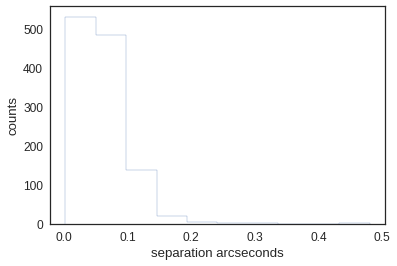

In [28]:
# I still limit the NSC catalog because 
# I want to get the cross matching time < 1 / H_0
# we don't expect dmag > 2 mag  between SDSS / NSC 
# if there were such discrepancy with a point source
# it's probably not too trustworthy...

m_mag = (rmin-2 < nsc['rmag'])*(nsc['rmag']<rmin+2)
m_dec = nsc['ra_W'] < 51
m_nsc = m_mag * m_dec
print('Against ', np.sum(m_nsc), ' NSC catalog sources...')

coords1 = SkyCoord(ra = dr_comb['ra'][m_qso]*u.degree, 
                   dec=dr_comb['dec'][m_qso]*u.degree) 
coords2 = SkyCoord(ra = nsc['ra_W'][m_nsc]*u.degree, 
                   dec= nsc['dec'][m_nsc]*u.degree) 

# this is matching HLC to NSC, so that indices are into NSC catalog
# makes sense in this case since the NSC catalog is bigger than HLC here 
idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)  
print('Done crossmatching')

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
qso = hstack([dr_comb[m_qso], nsc[m_nsc][idx]], table_names = ['sdss', 'nsc'])
qso['sep_2d_arcsec'] = d2d.arcsec

%matplotlib inline
# plot the separation , select only good matches : 
x = qso['sep_2d_arcsec']
plt.hist( x[x<0.5],histtype='step')
plt.xlabel('separation arcseconds')
plt.ylabel('counts')

Consider combining DR9 and DR12 , since they do not overlap too much ... But that's too much work for now.  It would include: 1) taking the DR9 catalog 2) matching to DR12 to check QSOs that are present in the new release 3) Add to DR12 those QSO that did not have a good match with DR9'

In [29]:
# Choose separation, and select only those object that have a nearest neighbor 
# from the NSC catalog within this radius ...
sep = 0.25
matched = qso['sep_2d_arcsec'] < sep
qsos =  qso[matched]
print('Of ', len(matched), ' QSO, we matched ', np.sum(matched), 'within ',sep,' arcsec')

Of  6455  QSO, we matched  1177 within  0.25  arcsec


"plot the median and sigmaG vs. RA for RA and Dec proper motion components for quasars with 17 < r < 20 from that file (~1 deg wide bins in RA, but try a factor of 3 smaller and larger bins and discuss)"

In [30]:
#qso

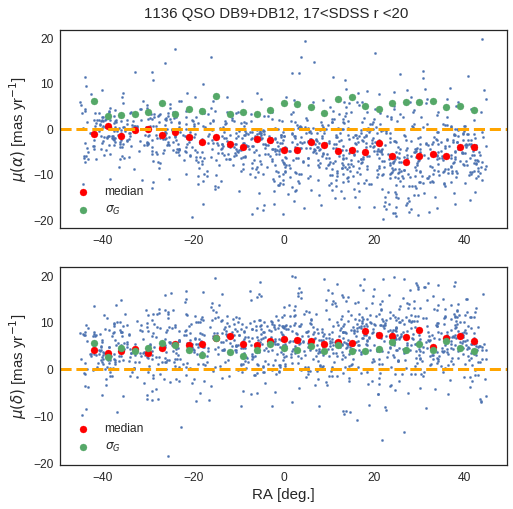

In [31]:
from scipy.stats import binned_statistic
from astroML import stats as astroMLstats
import seaborn as sns
sns.set(style='white', font_scale=1.2)

ra = qsos['ra_sdss']
dec = qsos['dec_sdss']
raPm = qsos['pmra']
decPm= qsos['pmdec']

bin_width = 3
bins = np.arange(min(ra), max(ra), bin_width)

fig,ax = plt.subplots(2,1,figsize=(8,8))

i = 0
for pm in [raPm, decPm] : 
    m = np.abs(pm) < 20 
    median = binned_statistic(ra[m], pm[m], statistic='median', bins=bins)
    sig = binned_statistic(ra[m], pm[m], statistic=astroMLstats.sigmaG, bins=bins)
    #im1 = ax[i].hexbin(ra[m], pm[m], bins='log', cmap=plt.cm.viridis,
    #           mincnt=1)
    ax[i].scatter(ra[m],pm[m], s=5, label='')
    ax[i].scatter(bins[1:], median.statistic, label='median', color='red')
    ax[i].scatter(bins[1:], sig.statistic, label=r'$\sigma_{G}$')
    ax[i].legend(fontsize=12, loc='lower left')
    ax[i].axhline(0,lw=3,ls='--', c='orange')
    i += 1 

ax[0].set_ylabel(r'$\mu({\alpha})$'+' [mas yr'+''+r'$^{-1}$'+']', fontsize=15)
ax[1].set_ylabel(r'$\mu({\delta})$'+' [mas yr'+''+r'$^{-1}$'+']', fontsize=15)
ax[1].set_xlabel('RA [deg.]', fontsize=15)
fig.suptitle(str(len(ra[m]))+' QSO DB9+DB12, 17<SDSS r <20', y=0.92, fontsize=15)
plt.savefig('hw2_2c_QSO_SDSS_NSC.png', bbox_inches='tight')

Quasars are very far away, so if all local motion is taken into account, there shouldn't be any tangential motion. There could be some radial motion (Hubble flow), but that's not what we are plotting above. 